In [2]:
import torch
import torch_geometric
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt
from data import zinc_complex3a6p_data_e3nn


In [2]:
irreps_input = o3.Irreps("128x0e")
o3.Irreps([(128, (0, 1))])
irreps_output = o3.Irreps("128x0e")

In [3]:
dataset = zinc_complex3a6p_data_e3nn.ZincComplex3a6pDataE3nn(data_dir='data/3a6p/zinc_drug_like_100k/3a6p_pocket5_202020')
dataloader = torch_geometric.loader.DataLoader(dataset, batch_size=1)

In [4]:
for data in dataloader:
    data
    break
data

DataBatch(x=[26], edge_index=[2, 56], edge_attr=[56, 3], y=[1], pos=[26, 3], id=[1], batch=[26], ptr=[2])

In [8]:
# data.edge_index
data.is_directed()

True

In [48]:
# create node positions
emd = torch.nn.Embedding(10, 128)
f_in = emd(data.x)
# num_nodes = 100
# pos = torch.randn(num_nodes, 3)  # random node positions
num_nodes = data.x.shape[0]
# create edges
max_radius = 2.0
# edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)
edge_src, edge_dst = data.edge_index
#
# print(edge_src.shape)
#
# edge_vec = pos[edge_dst] - pos[edge_src]
edge_vec = data.edge_attr
# o3.Linear()
# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

2.1538461538461537

In [49]:
# f_in = irreps_input.randn(num_nodes, -1)
# f_in.pow(2).mean()

In [50]:
# irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
irreps_sh = o3.Irreps('0e + 1e')
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh

sh.pow(2).mean(), sh.shape  # should be close to 1

1x0e+1x1e


(tensor(1.), torch.Size([56, 4]))

FullyConnectedTensorProduct(128x0e x 1x0e+1x1e -> 128x0e | 16384 paths | 16384 weights) needs 16384 weights


((<Figure size 432x288 with 1 Axes>, <AxesSubplot:>), 16384)

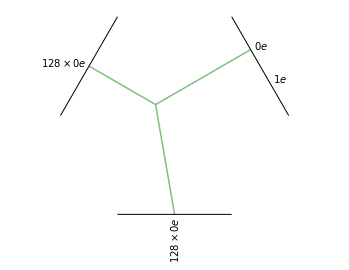

In [51]:
tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize(), tp.weight_numel

torch.Size([1000, 10])

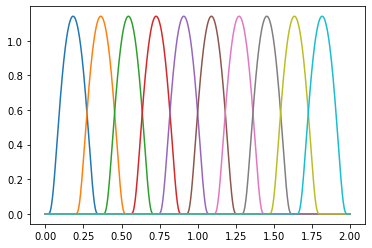

In [41]:
num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)

plt.plot(x, y);
y.shape

In [42]:
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_length_embedding.shape)
edge_length_embedding.pow(2).mean()  # the second moment

torch.Size([56, 10])


tensor(0.9988)

In [43]:
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
weight = fc(edge_length_embedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)

# For a proper notmalization, the weights also need to be mean 0
print(weight.mean(), weight.std())  # should close to 0 and 1

torch.Size([56, 16512])
56 16512
tensor(0.0021, grad_fn=<MeanBackward0>) tensor(1.1016, grad_fn=<StdBackward0>)


In [27]:
summand = tp(f_in[edge_src], sh, weight)

print(summand.shape)
print(summand.pow(2).mean())  # should be close to 1

torch.Size([56, 320])
tensor(0.8224, grad_fn=<MeanBackward0>)


In [28]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean(), f_out.shape  # should be close to 1

(tensor(0.8233, grad_fn=<MeanBackward0>), torch.Size([26, 320]))

In [13]:
def conv(f_in, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
    edge_vec = pos[edge_dst] - pos[edge_src]
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_basis, basis='smooth_finite', cutoff=True).mul(num_basis**0.5)
    return scatter(tp(f_in[edge_src], sh, fc(emb)), edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)

In [14]:
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

# rotate before
f_before = conv(f_in @ D_in.T, pos @ rot.T)

# rotate after
f_after = conv(f_in, pos) @ D_out.T

torch.allclose(f_before, f_after, rtol=1e-4, atol=1e-4)

True

In [1]:
import pytorch_lightning as pl
pl.__version__

'1.8.0.post1'

### 定义输入输出格式

In [14]:
# Just define arbitrary irreps
irreps_input = o3.Irreps("128x0e")
irreps_query = o3.Irreps("128x0e")
irreps_key = o3.Irreps("128x0e")
irreps_output = o3.Irreps("128x0e")  # also irreps of the values

In [15]:
num_nodes = 20

pos = torch.randn(num_nodes, 3)
f = irreps_input.randn(num_nodes, -1)

# create graph
max_radius = 1.3
edge_src, edge_dst = radius_graph(pos, max_radius)
edge_vec = pos[edge_src] - pos[edge_dst]
edge_length = edge_vec.norm(dim=1)

In [16]:
h_q = o3.Linear(irreps_input, irreps_query)

In [17]:
number_of_basis = 10
edge_length_embedded = soft_one_hot_linspace(
    edge_length,
    start=0.0,
    end=max_radius,
    number=number_of_basis,
    basis='smooth_finite',
    cutoff=True  # goes (smoothly) to zero at `start` and `end`
)
edge_length_embedded = edge_length_embedded.mul(number_of_basis**0.5)

In [18]:
from e3nn.math import soft_unit_step

edge_weight_cutoff = soft_unit_step(10 * (1 - edge_length / max_radius))

In [19]:
irreps_sh = o3.Irreps.spherical_harmonics(3)
edge_sh = o3.spherical_harmonics(irreps_sh, edge_vec, True, normalization='component')

In [20]:
tp_k = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_key, shared_weights=False)
fc_k = nn.FullyConnectedNet([number_of_basis, 16, tp_k.weight_numel], act=torch.nn.functional.silu)

tp_v = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)
fc_v = nn.FullyConnectedNet([number_of_basis, 16, tp_v.weight_numel], act=torch.nn.functional.silu)

In [21]:
dot = o3.FullyConnectedTensorProduct(irreps_query, irreps_key, "0e")

In [22]:
# compute the queries (per node), keys (per edge) and values (per edge)
q = h_q(f)
k = tp_k(f[edge_src], edge_sh, fc_k(edge_length_embedded))
v = tp_v(f[edge_src], edge_sh, fc_v(edge_length_embedded))

# compute the softmax (per edge)
exp = edge_weight_cutoff[:, None] * dot(q[edge_dst], k).exp()  # compute the numerator
z = scatter(exp, edge_dst, dim=0, dim_size=len(f))  # compute the denominator (per nodes)
z[z == 0] = 1  # to avoid 0/0 when all the neighbors are exactly at the cutoff
alpha = exp / z[edge_dst]

# compute the outputs (per node)
f_out = scatter(alpha.relu().sqrt() * v, edge_dst, dim=0, dim_size=len(f))

In [23]:
f_out.mean().item(), f_out.std().item()

(0.053782589733600616, 1.108964204788208)

In [19]:
from config import tune_config
from ray import tune

In [4]:
cfg = tune_config.config_tune('config/tune_cfg/tune_cfg_temp.yaml')

In [23]:
# cfg.pl_module.model
tune.grid_search([1, 2, 3])
# cfg.pl_module.model.to_dict()

{'grid_search': [1, 2, 3]}